# ENVIRONMENT

In [1]:
import numpy as np
import os

# to make reproducible results
np.random.seed(493)

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# for visualizations
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For saving vizzes
def save_fig(fig_id, tight_layout=True):
    path = "./viz/" + fig_id + ".png"
    print("Saving figure...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# ACQUIRE

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

_There are 70,000 images (rows) and each image has 784 features (columns)._

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

_Each of the features on an image simply represents a pixel and its intensity. Let's take a digit and reshape it into a 28x28 array and use `imshow` to display the digit._

Saving figure... digit_plot


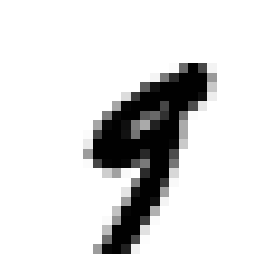

In [7]:
digit = X[36000]
digit_img = digit.reshape(28, 28)
plt.imshow(digit_img, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("digit_plot")
plt.show()

_The image above looks like a 9. Let's confirm this using its y label._

In [8]:
y[36000]

9

# SPLIT INTO TRAIN AND TEST SET

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

_We're going to shuffle that data so that our cross-validation folds will be similar. Also, some algorithms are sensitive to the training sample's order and usually perform poorly when the consecutive rows are similar._

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# BINARY CLASSIFIER

_Let's train a binary classifier that will predict whether the target is the number "5" or "not 5"._

In [11]:
# True for all instances of 5 and False for others.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## STOCHASTIC GRADIENT DESCENT
_This method is efficient in training a very large dataset._

In [12]:
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=493)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

_The number 9 is a "not 5" therefore it is predicted as false._

In [13]:
sgd_clf.predict([digit])

array([False])

## CROSS-VALIDATION

In [14]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9517 , 0.9497 , 0.94905])

_This is a manual implementation of cross-validation with 3 K-folds._

In [15]:
skfolds = StratifiedKFold(n_splits=3, random_state=493)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9517
0.9497
0.94905


## DUMB CLASSIFIER ON A SKEWED DATASET
_Only about 10% of the data is 5, the rest are 0-4 and 6-9, therefore, the dumb classifier will always predict a "not 5" and is consequently 90% accurate. That's why we should never just rely on accuracy to evaluate an algorithm's performance._

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91135, 0.91125, 0.90635])

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## CONFUSION MATRIX
_Precision and recall are better way to gauge a classifier's performance. Let's produce a confusion matrix that will give us these. But first, we need a set of predictions._

In [19]:
confusion_matrix(y_train_5, y_train_pred)

array([[52425,  2154],
       [  837,  4584]])

In [20]:
y_train_perfect_predictions = y_train_5

_The matrix..._

In [21]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

_TP / TP+FP_

In [22]:
precision_score(y_train_5, y_train_pred)

0.680320569902048

_TP / TP+FN_

In [23]:
recall_score(y_train_5, y_train_pred)

0.8456004427227449

_The harmonic mean of precision and recall._

In [24]:
f1_score(y_train_5, y_train_pred)

0.7540093757710338

_Manipulating with threshold a value._

In [25]:
y_scores = sgd_clf.decision_function([digit])
y_scores

array([-119103.61141191])

In [26]:
threshold = 0
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([False])

In [27]:
threshold = 200000
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure... precision_recall_vs_threshold_plot


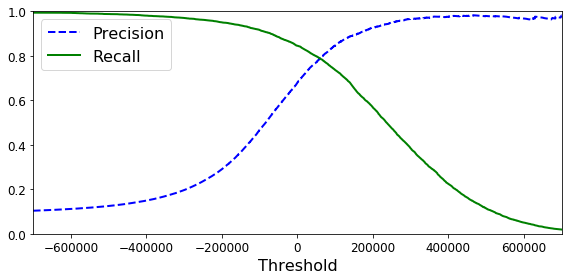

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [31]:
(y_train_pred == (y_scores > 0)).all()

True

In [32]:
y_train_pred_90 = (y_scores > 70000)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.8051997705983559

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.7769784172661871

Saving figure... precision_vs_recall_plot


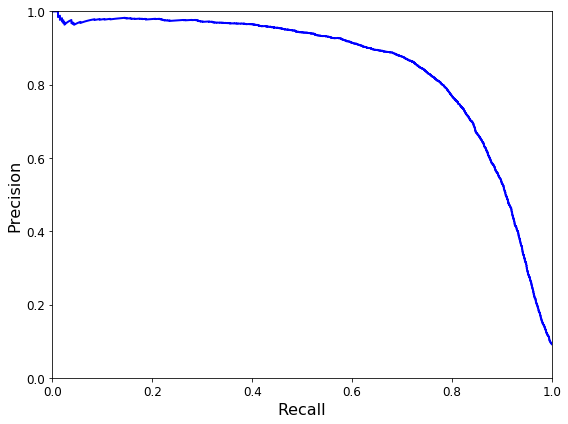

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
## THE ROC CURVE

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure... roc_curve_plot


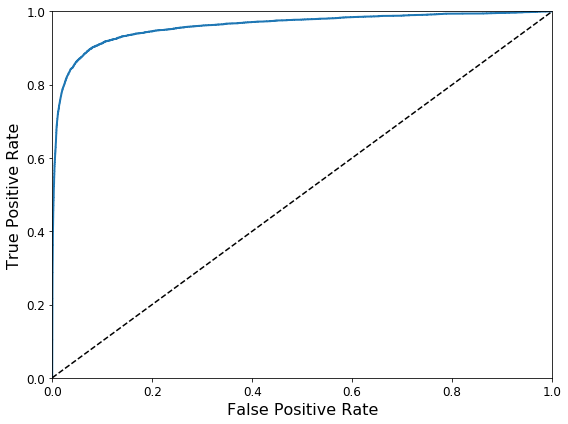

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

_A perfect classifier will have a score of 1 while a truly random one will have a .5 score._

In [38]:
roc_auc_score(y_train_5, y_scores)

0.9603725566367532

# RANDOM FOREST

In [39]:
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [40]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure... roc_curve_comparison_plot


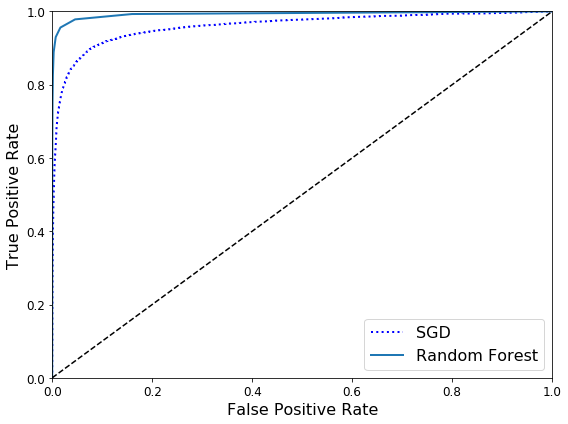

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928238662214928

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9831140350877193

In [44]:
recall_score(y_train_5, y_train_pred_forest)

0.8269691938756687

# KNN

In [45]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed: 61.1min remaining: 40.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 77.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [46]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [47]:
grid_search.best_score_

0.9730333333333333

In [48]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714